In [1]:
import sys
sys.path.append('../../../utils/')
from cmptTheoreticalEmitGrowth import *
from bunchLengthConversions import *
import csv
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [3]:
n_runs = 17 # number of runs that the simulation was repeated
n_turns = int(1e5)            # number of cycles to run the simulation for
decTurns = int(100)           # how often to record data
circumference  = 6911.5623 # [m]
f_rev  = 299792458/circumference  # [Hz] The revolution frequency of the machine 


In [4]:
separationTime = 1 / f_rev * decTurns #There are decTurns revolutions before each recording of data
tspan = (np.arange(n_turns / decTurns) + 1.0) * separationTime #total time spanned by the simulation

In [5]:
path_to_data = './wakesON'
study_name ='sps_270GeV_CC_PN1e-8_1e5turns_5e5Nb_wakefieldsON_500slices_ayy4000.0' 
noise_type = 'PN'
#PN_name_template = '{}_myteest'.format(type_of_noise)

In [6]:
ex_dict_pn = {} # type: dictionary
ey_dict_pn = {}

for run in range(n_runs):
    print(run)
    temp_name = 'run{}'.format(run) # the suffix of the name of the current study
    # A. load the turn by turn data in a dictionary
    meanX, meanY, meanXsq, meanYsq, emitX, emitY = np.loadtxt(path_to_data+f'/file_ayy4000.0_set{run}_run{run}.txt', delimiter = ",", unpack = True)
    # B. Create a different list for each run and save the emittance values
    ex_dict_pn[temp_name] = emitX 
    ey_dict_pn[temp_name] = emitY

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [7]:
### Compute the mean and the standard deviation over all runs

In [8]:
ex_mean_pn = []
ey_mean_pn = []

ex_std_pn = []
ey_std_pn = []

n_saved_turns = int(n_turns/decTurns)


for turn in range(n_saved_turns):
    ex_temp_pn = []
    ey_temp_pn = []

    # keep all the emittance values for all the runs
    for run in range(n_runs):
        temp_name = 'run{}'.format(run)
        ex_temp_pn.append(ex_dict_pn[temp_name][turn])
        ey_temp_pn.append(ey_dict_pn[temp_name][turn])
    # calculate and append the mean of the emittance value for every turn
    ex_mean_pn.append(np.mean(ex_temp_pn))
    ey_mean_pn.append(np.mean(ey_temp_pn))
    # calculate and append the standard deviation of the emittance value for every turn
    ex_std_pn.append(np.std(ex_temp_pn))
    ey_std_pn.append(np.std(ey_temp_pn))    

In [9]:
# Calculate the emittance growth with a linear fit
# linear fit
[m_y, b_y], cov_y = np.polyfit(tspan, ey_mean_pn, 1, cov=True)
# compute the error of the gradient of the fit slope
err_y = np.sqrt(np.diag(cov_y))
[m_x, b_x], cov_x = np.polyfit(tspan, ex_mean_pn, 1, cov=True)
# compute the error of the gradient of the fit slope
err_x = np.sqrt(np.diag(cov_x))

In [10]:
### Compute the theoretically expecte growth rate

In [11]:
# Machine parameters
betay = 73.81671646 # 73 m at CC2, 76 m at CC1
clight = 299792458 # m/s
Vcc = 1e6 # V
Eb = 200e9 # 270e9 eV
gamma_0 = 213.16 # for 200 GeV  # 287.8 for 270 GeV
beta_0 = np.sqrt(1 - 1/gamma_0**2)
circumference = 6911.5623 # m
frev = 299792458/circumference # Hz
tau = 2.2e-9 # 4 sigma_t [s] # 1.7e-9
sigma_z = clight*tau/4 #0.155  # m
print(f'sigma_z = {sigma_z} m')
f_CC = 400e6 # CC frequency in Hz

# Noise kick parameters
A_phase = 1e-8 # rms kick in the simulation of the phase noise
A_amplitude = 0 # rms kick in the simulation of the amplitude noise
scale_factor = Eb/Vcc # scaling factor to rms noise, σ
# Compute the PSD in rad^2/Hz and V^2/Hz
PSD_phi = (A_phase * scale_factor)**2/frev # rad^2/Hz
#PSD_phi = 1.42e-10
#PSD_phi = 1.4e-10
PSD_A = (A_amplitude * scale_factor)**2/frev # V^2/Hz
print(f'psd phi: {PSD_phi} rad^2/Hz, psd A: {PSD_A} V^2/Hz')

sigma_z = 0.1648858519 m
psd phi: 9.221796100020633e-11 rad^2/Hz, psd A: 0.0 V^2/Hz


In [12]:
# Compute the correction factor due to the bunch length
sigma_phi = bunch_length_m_to_rad(sigma_z, clight, f_CC)
CDeltaphi = cmpt_bunch_length_correction_factor(sigma_phi, 'PN')
CDeltaA = cmpt_bunch_length_correction_factor(sigma_phi, 'AN')
print('CDeltaPhi = {}, CDeltaA = {}'.format(CDeltaphi, CDeltaA))

if noise_type == 'PN':
    expected_growth = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C0'
    fill_bewtween_color = 'lightblue'
elif noise_type == 'AN':
    expected_growth = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    my_color = 'C1'
    fill_bewtween_color = 'moccasin'
else:
    my_color = 'C2'
    expected_growth_1 = emit_growth_phase_noise(betay, Vcc, frev, Eb, CDeltaphi, PSD_phi, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth_2 = emit_growth_amplitude_noise(betay, Vcc, frev, Eb, CDeltaA, PSD_A, one_sided_psd=False)*beta_0*gamma_0 # m/s
    expected_growth = expected_growth_1 + expected_growth_2

print('expected growth = {} nm/s'.format(expected_growth*1e9))

CDeltaPhi = 0.510947348428828, CDeltaA = 0.24452632578558595
expected growth = 17.435976910472817 nm/s


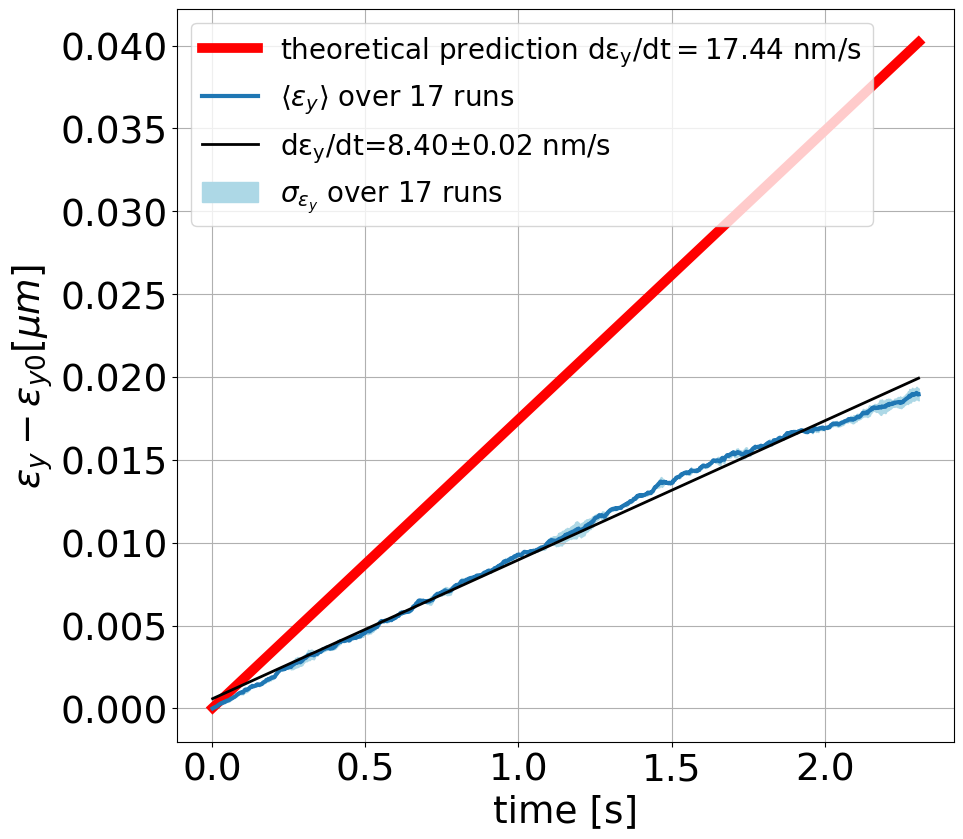

In [13]:
initial_std = ey_std_pn[0]
initial_mean_emittance = ey_mean_pn[0]
# std over all runs
plt.fill_between(tspan, np.array(ey_mean_pn-initial_mean_emittance )*1e6 - np.array(ey_std_pn-initial_std)*1e6, np.array(ey_mean_pn-initial_mean_emittance)*1e6 + np.array(ey_std_pn-initial_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_y}$'+ ' over {} runs'.format(n_runs))

# expected slope from analytical calculations
plt.plot(tspan, (expected_growth*tspan)*1e6, c='r', linewidth=7, label= 'theoretical prediction '+r'$\mathrm{d\epsilon _y/dt=}$'+'{0:.2f} nm/s'.format(expected_growth*1e9))

# emittance values obtained from the simulation averaged over turns
plt.plot(tspan, np.array(ey_mean_pn-initial_mean_emittance)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_y \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
plt.plot(tspan, (b_y-initial_mean_emittance)*1e6+(m_y*tspan)*1e6, c = 'k', label=r'$\mathrm{d\epsilon_y/dt}$'+'={0:.2f}'.format(m_y*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_y[0]*1e9), linewidth = 2)


#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_y - \epsilon_{y0} [\mu m]$')
plt.legend(loc=0)
plt.grid()
#plt.ylim(0,0.08) # 0.3
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig(f'./output/dey_{study_name}_mean{n_runs}run_fill_between_v2.png', bbox_inches='tight')
plt.show()

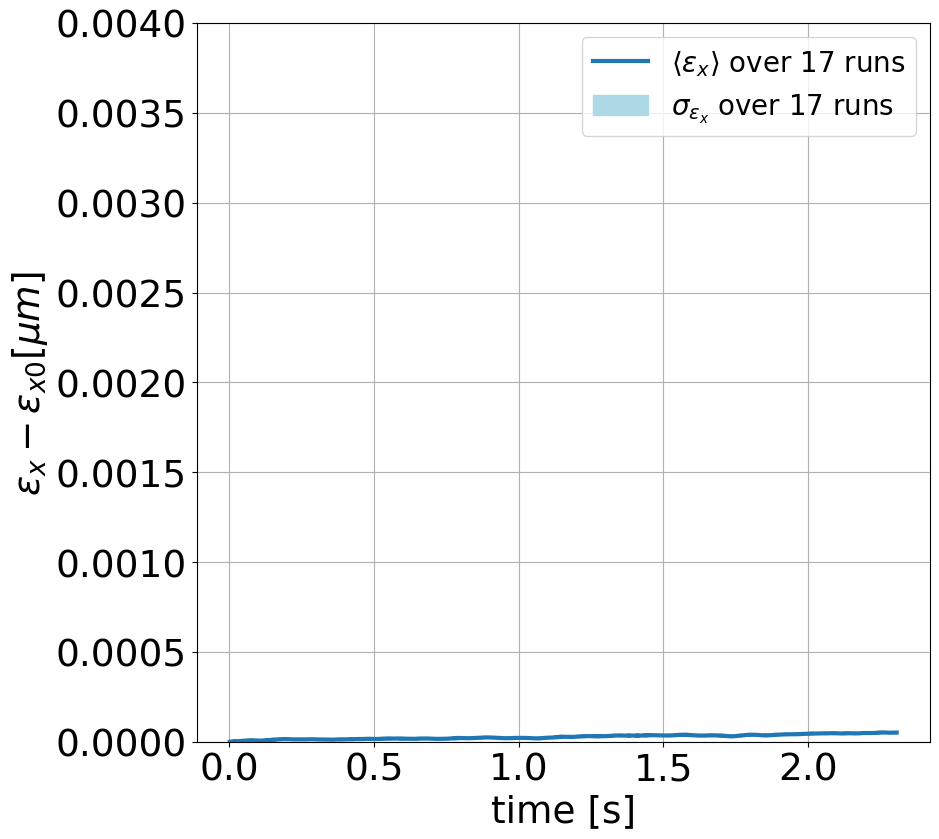

In [16]:
initial_std = ex_std_pn[0]
initial_mean_emittance = ex_mean_pn[0]
# std over all runs
plt.fill_between(tspan, np.array(ex_mean_pn-initial_mean_emittance )*1e6 - np.array(ex_std_pn-initial_std)*1e6, np.array(ex_mean_pn-initial_mean_emittance)*1e6 + np.array(ex_std_pn-initial_std)*1e6, color=fill_bewtween_color, label=r'$\sigma_{\epsilon_x}$'+ ' over {} runs'.format(n_runs))

# emittance values obtained from the simulation averaged over turns
plt.plot(tspan, np.array(ex_mean_pn-initial_mean_emittance)*1e6, c=my_color, linewidth=3, label=r'$\langle \epsilon_x \rangle $'+' over {} runs'.format(n_runs))

# linear fit on the emittance values obtained from the simulation averaged over turns
#plt.plot(tspan, (b_y-initial_mean_emittance)*1e6+(m_y*tspan)*1e6, c = 'k', label=r'$\mathrm{d\epsilon_y/dt}$'+'={0:.2f}'.format(m_y*1e9)+'$\pm$'+'{0:.2f} nm/s'.format(err_y[0]*1e9), linewidth = 2)


#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.xlabel('time [s]')
plt.ylabel(r'$\epsilon_x - \epsilon_{x0} [\mu m]$')
plt.legend(loc=0)
plt.grid()
plt.ylim(0,0.004) # 0.3
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig(f'./output/dex_{study_name}_mean{n_runs}run_fill_between_v2.png', bbox_inches='tight')
plt.show()